# Final project: predict future sales

This challenge serves as final project for the "How to win a data science competition" Coursera course.
In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm_notebook

from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [2]:
DATA_FOLDER = '../readonly/final_project_data/'

sales    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
train           = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'), compression='gzip')
test           = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))

# EDA

Shape of the loaded dataframes

In [3]:
print ('sales shape %s' % np.str(sales.shape))
print ('items shape %s' % np.str(items.shape))
print ('item_categories shape %s' % np.str(item_categories.shape))
print ('shops shape %s' % np.str(shops.shape))
print ('train shape %s' % np.str(train.shape))
print ('test shape %s' % np.str(test.shape))

sales shape (2935849, 6)
items shape (22170, 3)
item_categories shape (84, 2)
shops shape (60, 2)
train shape (2935849, 6)
test shape (214200, 3)


#### Browse data heads to get an idea of the data

In [4]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Note. The negative values in item_cnt_day are returned items

In [5]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [9]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


#### Let's join the data to get the consolidated base data frame

1st I add category description to the items df

In [10]:
items_merge = pd.merge(left = items, right = item_categories , left_on = 'item_category_id', right_on = 'item_category_id')

In [11]:
print (items_merge.head())

                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
2    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
3        ***КОРОБКА (СТЕКЛО)                       D        4   
4  ***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ  (UNI)         ...        5   

   item_category_id item_category_name  
0                40         Кино - DVD  
1                40         Кино - DVD  
2                40         Кино - DVD  
3                40         Кино - DVD  
4                40         Кино - DVD  


Then I add the category to the items sold

In [12]:
sales_merge = pd.merge(left = sales,right = items_merge, left_on ='item_id', right_on = 'item_id' )

In [13]:
print (sales_merge.head())

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154       999.0           1.0   
1  23.01.2013               0       24    22154       999.0           1.0   
2  20.01.2013               0       27    22154       999.0           1.0   
3  02.01.2013               0       25    22154       999.0           1.0   
4  03.01.2013               0       25    22154       999.0           1.0   

           item_name  item_category_id item_category_name  
0  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray  
1  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray  
2  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray  
3  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray  
4  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray  


check the time span of the training data

In [14]:
dates_df = pd.to_datetime(sales_merge['date'],format='%d.%m.%Y')
print ('Sale from %s to %s' % (str(dates_df.min()),str(dates_df.max())))

Sale from 2013-01-01 00:00:00 to 2015-10-31 00:00:00


#### Note. 2 years & 10 months of sales data. I need to predict the sales in November 2015

### Data Analysis

#### 1st Visualize the sales over the train period by grouping the items sold by month

In [15]:
aggrMonth = sales_merge.groupby(['date_block_num'])[['item_cnt_day']].sum()

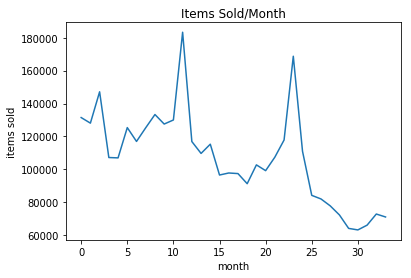

In [16]:
plt.clf()
plt.plot(aggrMonth.item_cnt_day)
plt.title ("Items Sold/Month")
plt.xlabel("month") 
plt.ylabel("items sold") 
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

Some observations from the plot are the follows:
* There may be an decreasing trend of sales over time.
* There appears to be systematic seasonality to the sales for each year.
* The seasonality suggests that the series is almost certainly non-stationary.
* We can can notice a sharp increase followed by a sharp decrease around the spikes. We should be able to be exploited this trend by adding lagged features.

I am going to visualize the seasonality by plotting 2013 & 2014 on 2 separate plots 

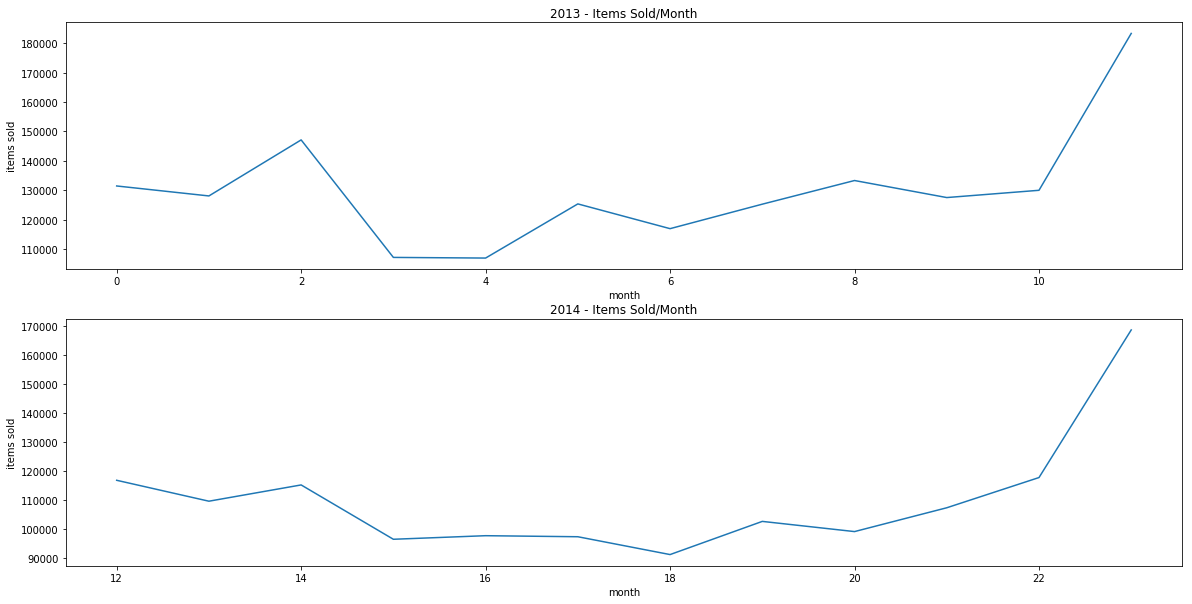

In [17]:
plt.clf()
plt.figure(1)
plt.subplot(211)
plt.plot(aggrMonth.iloc[0:12].item_cnt_day)
plt.title ("2013 - Items Sold/Month")
plt.xlabel("month") 
plt.ylabel("items sold") 
plt.rcParams["figure.figsize"] = (20,10)

plt.subplot(212)
plt.plot(aggrMonth.iloc[12:24].item_cnt_day)
plt.title ("2014 - Items Sold/Month")
plt.xlabel("month") 
plt.ylabel("items sold") 
plt.rcParams["figure.figsize"] = (20,10)

plt.show()

#### 2nd Visualize the sales grouping the items sold by shop_id

In [18]:
aggrShop = sales_merge.groupby(['shop_id'])[['item_cnt_day']].sum()

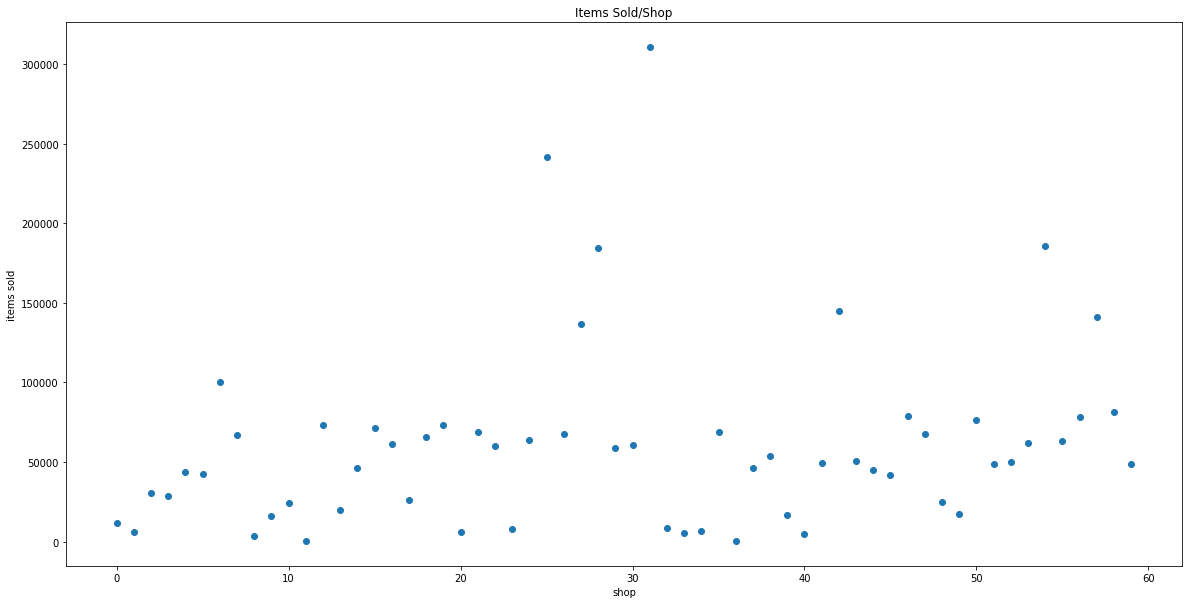

In [19]:
plt.clf()
plt.scatter(x = aggrShop.index ,y=aggrShop.item_cnt_day)
plt.title ("Items Sold/Shop")
plt.xlabel("shop") 
plt.ylabel("items sold") 
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

A bunch of shops sold more than 100000 items. 
Let's check whether these figures make sense or they can be excluded.

In [20]:
top_sellers = aggrShop[aggrShop['item_cnt_day'] > 100000]

In [21]:
top_sellers.sort_values('item_cnt_day',ascending = False)

,item_cnt_day
shop_id,
31,310777.0
25,241920.0
54,185790.0
28,184557.0
42,144934.0
57,141107.0
27,136657.0
6,100489.0


In [22]:
sales_top_sellers = sales[sales['shop_id'].isin(top_sellers.index)]

In [23]:
sales_top_sellers['item_cnt_day'].describe()

count    1.122164e+06
mean     1.288788e+00
std      2.148954e+00
min     -6.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      5.020000e+02
Name: item_cnt_day, dtype: float64

In [24]:
sales['item_cnt_day'].describe()

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

In [25]:
top_sellers_detail = sales_merge[sales_merge['shop_id'].isin(top_sellers.index)] 

In [26]:
aggrShopItemTopSales = top_sellers_detail.groupby(['shop_id','item_id'])[['item_cnt_day']].sum()

In [27]:
aggrShopItemTopSales.head()

item_cnt_day
shop_id item_id              
6       27                1.0
        28                1.0
        29                1.0
        30               51.0
        31               48.0

In [28]:
aggrShopItemTopSales.sort_values('item_cnt_day',ascending = False)

,,item_cnt_day
shop_id,item_id,
31,20949,19934.0
25,20949,14343.0
28,20949,13458.0
54,20949,12323.0
42,20949,10514.0
27,20949,8265.0
57,20949,6116.0
6,20949,3551.0
31,5822,1293.0


In [29]:
items_merge[items_merge['item_id'].isin(aggrShopItemTopSales[aggrShopItemTopSales['item_cnt_day']>500].index[1])]

,item_name,item_id,item_category_id,item_category_name
5,***УДАР ПО ВОРОТАМ (UNI) D,6,40,Кино - DVD
7979,"Grand Theft Auto V [PS3, русские субтитры]",3732,19,Игры - PS3


In [30]:
items_aggr = top_sellers_detail.groupby(['item_id'])['item_cnt_day'].sum()

In [31]:
items_aggr[items_aggr > 0].sort_values(ascending = False)

item_id
20949    88504.0
3732      5735.0
17717     5298.0
5822      5056.0
2808      5049.0
3734      3748.0
16787     3426.0
6675      3255.0
1855      3184.0
7856      3017.0
3731      2866.0
5823      2636.0
6738      2603.0
4870      2603.0
2445      2574.0
3331      2561.0
16790     2320.0
7894      2269.0
4181      2223.0
13071     2179.0
5821      2165.0
6740      2136.0
3928      2134.0
3733      2128.0
2814      2120.0
2308      2087.0
6498      2074.0
5672      2058.0
3183      2053.0
6503      2048.0
6497      2040.0
22088     1998.0
1830      1952.0
1916      1936.0
2269      1934.0
15044     1919.0
6457      1911.0
7096      1860.0
9355      1827.0
16169     1826.0
7893      1785.0
10210     1778.0
21404     1748.0
4178      1747.0
5272      1723.0
3329      1702.0
16227     1699.0
6466      1639.0
3343      1634.0
6495      1633.0
3342      1622.0
2753      1599.0
9242      1596.0
10298     1595.0
21440     1585.0
7018      1574.0
3341      1551.0
7807      1542.0
4231  

In [32]:
aggrShop.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59],
           dtype='int64', name='shop_id')

In [33]:
aggrShopItemTopSales[aggrShopItemTopSales['item_cnt_day']>0].sort_values('item_cnt_day',inplace = True)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
aggrShopItemTopSales

item_cnt_day
shop_id item_id              
6       27                1.0
        28                1.0
        29                1.0
        30               51.0
        31               48.0
        32               58.0
        33               42.0
        34                2.0
        35                3.0
        36                1.0
        37                2.0
        38                1.0
        40                1.0
        41                2.0
        42                4.0
        44               11.0
        45                3.0
        46                2.0
        47                6.0
        48                3.0
        49               11.0
        51               10.0
        52                1.0
        53               10.0
        55                3.0
        56                1.0
        57                1.0
        59                9.0
        60                1.0
        62                3.0
        64                2.0
        65                2.0
        66                2.0
        67                2.0
        70                2.0
        76               12.0
        77               27.0
        78                7.0
        85                3.0
        88                2.0
        90                7.0
        91               11.0
        93                1.0
        96                3.0
        97                7.0
        98                6.0
        99                3.0
        109               4.0
        111               3.0
        113               6.0
        149               2.0
        152               1.0
        153               2.0
        154               4.0
        155               4.0
        156               6.0
        166               2.0
        177               3.0
        197               3.0
        199               4.0
        202               3.0
        210               1.0
        213               5.0
        226               3.0
        228               2.0
        230               2.0
        246               1.0
        253               2.0
        257               1.0
        258               2.0
        259               6.0
        264               1.0
        282               3.0
        293               2.0
        294               1.0
        295               1.0
        308               7.0
        317               1.0
        320               1.0
        321               1.0
        325               3.0
        357               1.0
        373               6.0
        375               1.0
        385               1.0
        388               5.0
        389               1.0
        408               1.0
        410               3.0
        413               1.0
        421               2.0
        439               1.0
        448               3.0
        462               1.0
        464              13.0
        472               6.0
        477               1.0
        481               1.0
        482              36.0
        484              16.0
        485              54.0
        486              44.0
        491              13.0
        494               3.0
        496               1.0
        498               2.0
        534              14.0
        541               1.0
        544               1.0
        546               1.0
        548               1.0
        551               1.0
        553               3.0
        554               2.0
        555               1.0
        556              11.0
        557               2.0
        558               7.0
        560              15.0
        562               1.0
        565               4.0
        625               1.0
        626               1.0
        628               1.0
        638               6.0
        642              12.0
        651              15.0
        657               9.0
        677               9.0
        687              18.0
        700              29.0
        715               1

### Missing Data 

In [35]:
# missing values?
sales_merge.isnull().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
dtype: int64

No missing data, all columns have been populated

I visualize how prices are distributed to understand whether there are some dummy values & outliers.

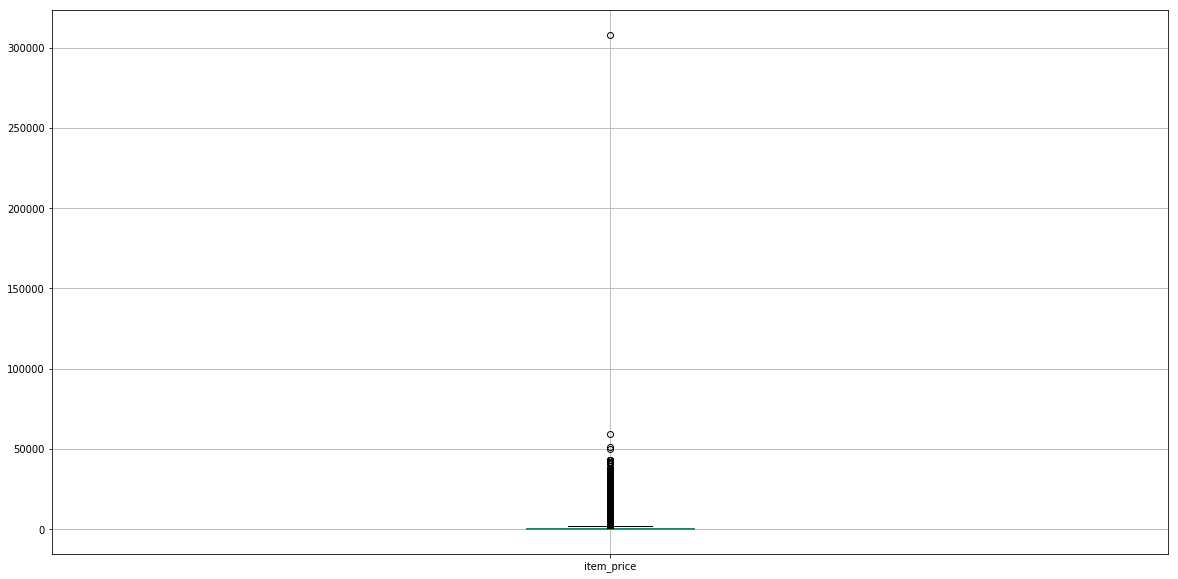

In [36]:
sales_merge.boxplot(column = 'item_price')      

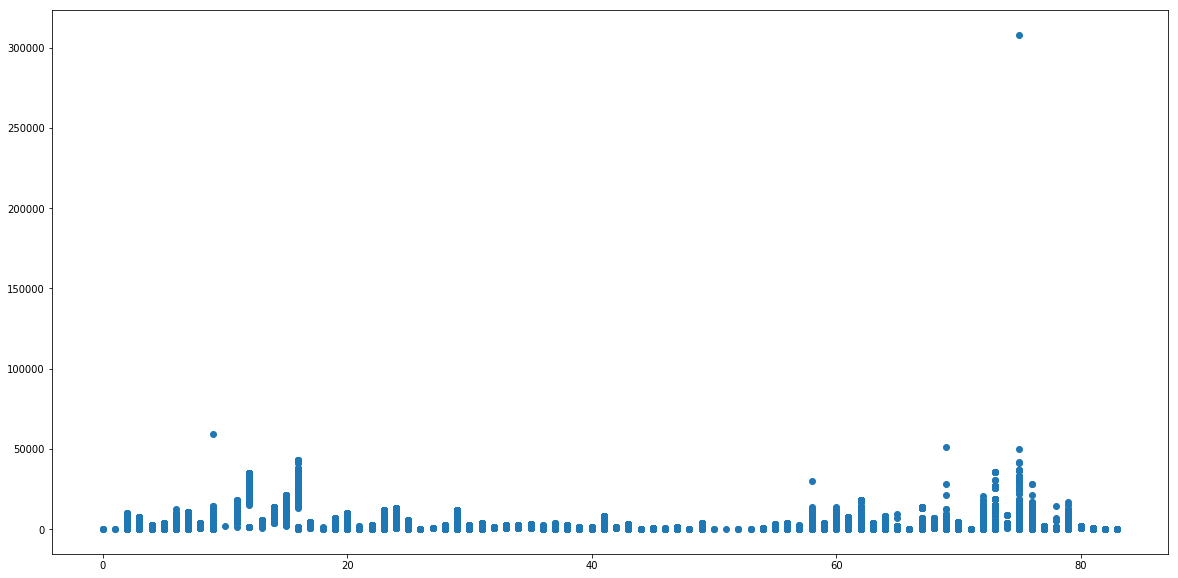

In [37]:
plt.scatter(sales_merge.item_category_id,sales_merge.item_price)
plt.show()

What I did is the following:
* 1st I have checked the prices alone & noticed that most prices are < 100000. 
* Then I have checked the distribution of prices over the item categories & observed that the price > 100000 should be an outlier

Now I quantify the items that are extremely highly priced to confirm I can remove them from the data

In [38]:
sales_merge[sales_merge.item_price > 100000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
2163826,13.12.2013,11,12,6066,307980.0,1.0,Radmin 3 - 522 лиц.,75,Программы - Для дома и офиса


In [39]:
sales_merge[sales_merge.item_category_id == 75]['item_price'].mean()

1859.8670734734765

#### Note. The high price is probably a typo. I updated the data with the mean

In [40]:
sales_merge.at[2163826, 'item_price'] = 1859

In [41]:
sales_merge.iloc[2163826]

date                                    13.12.2013
date_block_num                                  11
shop_id                                         12
item_id                                       6066
item_price                                    1859
item_cnt_day                                     1
item_name                     Radmin 3  - 522 лиц.
item_category_id                                75
item_category_name    Программы - Для дома и офиса
Name: 2163826, dtype: object

## Gaio Data Cleansing

In [42]:
sales.at[2163826, 'item_price'] = 1859
sales = sales[sales.item_cnt_day<=1000]

# Features generation

### Add 1st the test data

In [43]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [44]:
all_data_cols = list(sales)
df_test_append = pd.DataFrame(index=test.index, columns=all_data_cols)
df_test_append = df_test_append.fillna(0)
df_test_append['shop_id'] = test['shop_id']
df_test_append['item_id'] = test['item_id']
df_test_append['date_block_num'] = 34

In [45]:
df_test_append.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,34,5,5037,0,0
1,0,34,5,5320,0,0
2,0,34,5,5233,0,0
3,0,34,5,5232,0,0
4,0,34,5,5268,0,0


In [46]:
sales = pd.concat((sales, df_test_append)).reset_index(drop=True)
print("all_data size is : {}".format(sales.shape))

all_data size is : (3150048, 6)


### Create a DF with all combination of month, shop & item

This is important because in the months we don't have a data for an item store combination, the machine learning algorithm needs to be specifically told that the sales is zero.

In [47]:
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [48]:
sales_merge = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()
sales_merge = pd.merge(grid,sales_merge,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)
# adding the category id too
sales_merge = pd.merge(sales_merge,items,on=['item_id'],how='left')

In [49]:
sales_merge.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59


### Create the mean encodings 

In [50]:
for type_id in ['item_id','shop_id','item_category_id']:
    for column_id,aggregator,aggtype in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:

        mean_df = sales_merge.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'date_block_num']

        sales_merge = pd.merge(sales_merge,mean_df,on=['date_block_num',type_id],how='left')

In [51]:
sales_merge.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,310.800000,18.0,0.400000,97.974472,2017.0,0.248552,63.014719,6094.0,0.199738
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,19.977778,0.0,0.000000,97.974472,2017.0,0.248552,54.898665,287.0,0.043386
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,37.978889,1.0,0.022222,97.974472,2017.0,0.248552,54.898665,287.0,0.043386
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,48.837778,2.0,0.044444,97.974472,2017.0,0.248552,38.267019,268.0,0.049630
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,36.400000,5.0,0.111111,97.974472,2017.0,0.248552,35.593867,701.0,0.093280


After having create the grid, I add the lags up to 1 year before to leverage the sales seasonality

In [52]:
cols_to_rename = list(sales_merge.columns[7:]) + ['item_cnt_day']
print (cols_to_rename)

['item_id_avg_item_price', 'item_id_sum_item_cnt_day', 'item_id_avg_item_cnt_day', 'shop_id_avg_item_price', 'shop_id_sum_item_cnt_day', 'shop_id_avg_item_cnt_day', 'item_category_id_avg_item_price', 'item_category_id_sum_item_cnt_day', 'item_category_id_avg_item_cnt_day', 'item_cnt_day']


In [53]:
gc.collect();
from tqdm import tqdm_notebook

shift_range = [1, 2, 3, 4, 5, 12]

sales_merge = downcast_dtypes(sales_merge)

for month_shift in tqdm_notebook(shift_range):
    print("passa %s\n" % str(month_shift))
    train_shift = sales_merge[index_cols + cols_to_rename].copy()
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)
    sales_merge = pd.merge(sales_merge, train_shift, on=index_cols, how='left').fillna(0)
    del train_shift
    
gc.collect();

A Jupyter Widget

passa 1

passa 2

passa 3

passa 4

passa 5

passa 12




In [54]:
sales_merge.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,shop_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,...,shop_id_avg_item_cnt_day_lag_4,item_category_id_avg_item_price_lag_4,item_category_id_sum_item_cnt_day_lag_4,item_category_id_avg_item_cnt_day_lag_4,item_cnt_day_lag_4,item_id_avg_item_price_lag_5,item_id_sum_item_cnt_day_lag_5,item_id_avg_item_cnt_day_lag_5,shop_id_avg_item_price_lag_5,shop_id_sum_item_cnt_day_lag_5,shop_id_avg_item_cnt_day_lag_5,item_category_id_avg_item_price_lag_5,item_category_id_sum_item_cnt_day_lag_5,item_category_id_avg_item_cnt_day_lag_5,item_cnt_day_lag_5,item_id_avg_item_price_lag_12,item_id_sum_item_cnt_day_lag_12,item_id_avg_item_cnt_day_lag_12,shop_id_avg_item_price_lag_12,shop_id_sum_item_cnt_day_lag_12,shop_id_avg_item_cnt_day_lag_12,item_category_id_avg_item_price_lag_12,item_category_id_sum_item_cnt_day_lag_12,item_category_id_avg_item_cnt_day_lag_12,item_cnt_day_lag_12
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,310.799988,18.0,0.400000,97.974472,2017.0,0.248552,63.014717,6094.0,0.199738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,19.977777,0.0,0.000000,97.974472,2017.0,0.248552,54.898666,287.0,0.043386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,37.978889,1.0,0.022222,97.974472,2017.0,0.248552,54.898666,287.0,0.043386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,48.837776,2.0,0.044444,97.974472,2017.0,0.248552,38.267017,268.0,0.049630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,36.400002,5.0,0.111111,97.974472,2017.0,0.248552,35.593868,701.0,0.093280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Fill NaN with 0

In [55]:
for feat in sales_merge.columns:
    if 'item_cnt' in feat:
        sales_merge[feat]=sales_merge[feat].fillna(0)
    elif 'item_price' in feat:
        sales_merge[feat]=sales_merge[feat].fillna(sales_merge[feat].median())

In [56]:
sales_merge.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,shop_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,...,shop_id_avg_item_cnt_day_lag_4,item_category_id_avg_item_price_lag_4,item_category_id_sum_item_cnt_day_lag_4,item_category_id_avg_item_cnt_day_lag_4,item_cnt_day_lag_4,item_id_avg_item_price_lag_5,item_id_sum_item_cnt_day_lag_5,item_id_avg_item_cnt_day_lag_5,shop_id_avg_item_price_lag_5,shop_id_sum_item_cnt_day_lag_5,shop_id_avg_item_cnt_day_lag_5,item_category_id_avg_item_price_lag_5,item_category_id_sum_item_cnt_day_lag_5,item_category_id_avg_item_cnt_day_lag_5,item_cnt_day_lag_5,item_id_avg_item_price_lag_12,item_id_sum_item_cnt_day_lag_12,item_id_avg_item_cnt_day_lag_12,shop_id_avg_item_price_lag_12,shop_id_sum_item_cnt_day_lag_12,shop_id_avg_item_cnt_day_lag_12,item_category_id_avg_item_price_lag_12,item_category_id_sum_item_cnt_day_lag_12,item_category_id_avg_item_cnt_day_lag_12,item_cnt_day_lag_12
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,310.799988,18.0,0.400000,97.974472,2017.0,0.248552,63.014717,6094.0,0.199738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,19.977777,0.0,0.000000,97.974472,2017.0,0.248552,54.898666,287.0,0.043386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,37.978889,1.0,0.022222,97.974472,2017.0,0.248552,54.898666,287.0,0.043386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,48.837776,2.0,0.044444,97.974472,2017.0,0.248552,38.267017,268.0,0.049630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,36.400002,5.0,0.111111,97.974472,2017.0,0.248552,35.593868,701.0,0.093280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Drop the columns that I am not going to use for training the model

In [57]:
to_drop_cols = cols_to_rename + ['item_name','item_price']
print (to_drop_cols)

['item_id_avg_item_price', 'item_id_sum_item_cnt_day', 'item_id_avg_item_cnt_day', 'shop_id_avg_item_price', 'shop_id_sum_item_cnt_day', 'shop_id_avg_item_cnt_day', 'item_category_id_avg_item_price', 'item_category_id_sum_item_cnt_day', 'item_category_id_avg_item_cnt_day', 'item_cnt_day', 'item_name', 'item_price']


### Get just recent data

In [58]:
sales_merge = sales_merge[sales_merge['date_block_num']>12]

### Train/Validation/Test split

I will train on the 1st 32 months & validate on the last month

In [59]:
print ('1st month: %s , last month: %s' % (str(sales_merge['date_block_num'].min()),str(sales_merge['date_block_num'].max())))

1st month: 13 , last month: 34


In [60]:
y_train = sales_merge.loc[sales_merge['date_block_num']<33]['item_cnt_day']
y_val =  sales_merge.loc[sales_merge['date_block_num'] == 33]['item_cnt_day']

X_train = sales_merge[sales_merge['date_block_num']<33].drop(to_drop_cols, axis=1)
X_val =  sales_merge[sales_merge['date_block_num']==33].drop(to_drop_cols, axis=1)
X_test = sales_merge[sales_merge['date_block_num']==34].drop(to_drop_cols, axis=1)

X_final_train = sales_merge[sales_merge['date_block_num']<34].drop(to_drop_cols, axis=1)
y_final_train = sales_merge.loc[sales_merge['date_block_num']<34]['item_cnt_day']

### Clip the training target in the range [0,40]

In [61]:
y_train=np.clip(y_train,0, 40)
y_val=np.clip(y_val,0, 40)
y_final_train = np.clip(y_final_train,0, 40)

# Modeling & Stacking

### Define the loss function - RMSE

In [62]:
def rmse(X,y):
    return np.sqrt(mean_squared_error(X, y))

### Select most important features with LightGBM

In [63]:
import lightgbm as lgb
#GAIO Update 20.12.2017.3 - updated lgb params
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0,
                'early_stopping_rounds' :1,
                'eval_metric':'rmse'
              }

#GAIO Update 20.12.2017.3 - introduced early stopping having noticed the model overfitting
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

model_lgb = lgb.train(lgb_params,                     
                      lgb_train,
                      num_boost_round=500,
                      valid_sets=lgb_eval,
                      early_stopping_rounds=5)

C:\Users\User\Anaconda3\lib\site-packages\lightgbm\engine.py:103: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.38274
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's rmse: 1.36713
[3]	valid_0's rmse: 1.35243
[4]	valid_0's rmse: 1.33879
[5]	valid_0's rmse: 1.32609
[6]	valid_0's rmse: 1.31389
[7]	valid_0's rmse: 1.30519
[8]	valid_0's rmse: 1.2958
[9]	valid_0's rmse: 1.28677
[10]	valid_0's rmse: 1.27799
[11]	valid_0's rmse: 1.26858
[12]	valid_0's rmse: 1.25973
[13]	valid_0's rmse: 1.25127
[14]	valid_0's rmse: 1.24517
[15]	valid_0's rmse: 1.23813
[16]	valid_0's rmse: 1.23198
[17]	valid_0's rmse: 1.2258
[18]	valid_0's rmse: 1.21992
[19]	valid_0's rmse: 1.21522
[20]	valid_0's rmse: 1.21084
[21]	valid_0's rmse: 1.20595
[22]	valid_0's rmse: 1.20198
[23]	valid_0's rmse: 1.19775
[24]	valid_0's rmse: 1.19338
[25]	valid_0's rmse: 1.18906
[26]	valid_0's rmse: 1.18551
[27]	valid_0's rmse: 1.18223
[28]	valid_0's rmse: 1.18023
[29]	valid_0's rmse: 1.17693
[30]	valid_0's rmse: 1.17376
[31]	valid_0's rmse: 1.17102
[32]	valid_0's rmse: 1.16804
[33]	valid_0's rmse: 1

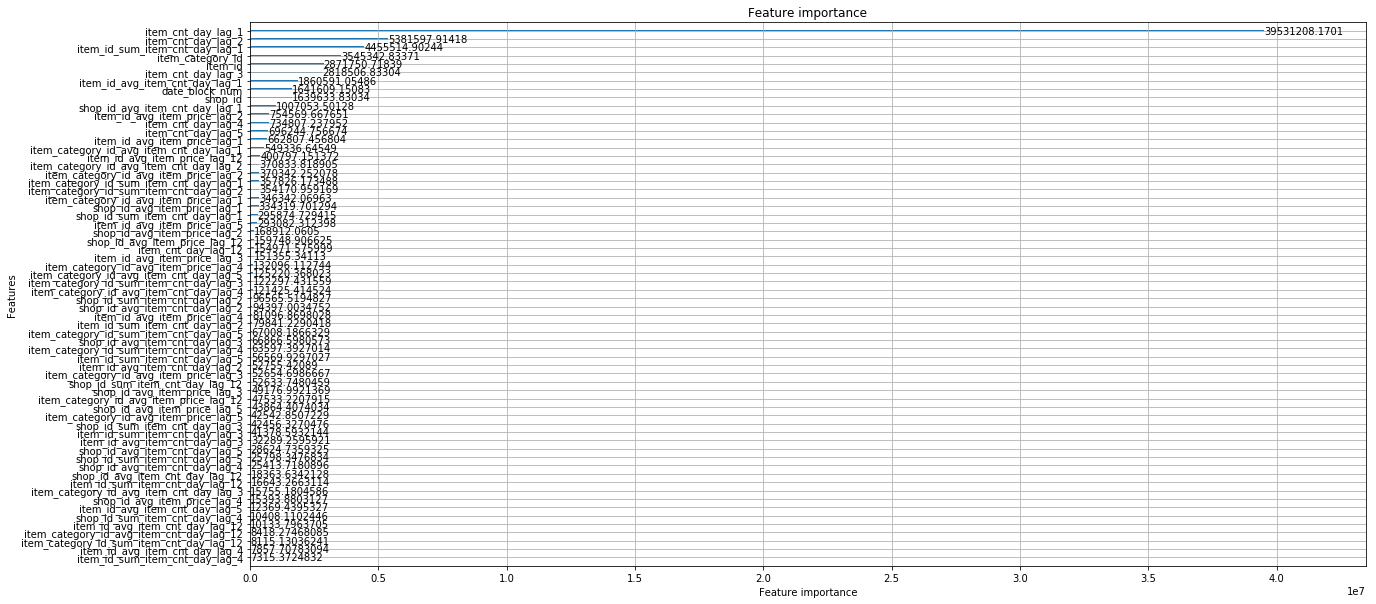

In [64]:
lgb.plot_importance(model_lgb,importance_type='gain')

### Tune LightGBM with Hyperopt

LightGBM uses the leaf-wise tree growth algorithm, while many other popular tools use depth-wise tree growth. Compared with depth-wise growth, the leaf-wise algorithm can convenge much faster. However, the leaf-wise growth may be over-fitting if not used with the appropriate parameters.

To get good results using a leaf-wise tree, these are some important parameters:

* num_leaves. This is the main parameter to control the complexity of the tree model. Theoretically, we can set num_leaves = 2^(max_depth) to convert from depth-wise tree. However, this simple conversion is not good in practice. The reason is, when number of leaves are the same, the leaf-wise tree is much deeper than depth-wise tree. As a result, it may be over-fitting. Thus, when trying to tune the num_leaves, we should let it be smaller than 2^(max_depth). For example, when the max_depth=6 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise. Actually, the concept depth can be forgotten in leaf-wise tree, since it doesn't have a correct mapping from leaves to depth.
* min_data_in_leaf. This is a very important parameter to deal with over-fitting in leaf-wise tree. Its value depends on the number of training data and num_leaves. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.
* max_depth. You also can use max_depth to limit the tree depth explicitly.

In [65]:
from sklearn.metrics import mean_squared_error
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

def objective(space):
    print(space)
    
    lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'max_depth' : int(space['max_depth']),
               'num_leaves': int(space['num_leaves']),
               'min_data_in_leaf': int(space['min_data_in_leaf']), 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': int(space['bagging_seed']), 
               'bagging_freq':1,
               'verbose':0,
                'early_stopping_rounds' :1,
                'eval_metric':'rmse'
              }
    opt_lgb = lgb.train(lgb_params,                     
                      lgb_train,
                      num_boost_round=500,
                      valid_sets=lgb_eval,
                      early_stopping_rounds=5)
    
    pred = opt_lgb.predict(X_val)
    mse_scr = mean_squared_error(y_val, pred)
    print ("SCORE:", np.sqrt(mse_scr))
    return {'loss':mse_scr, 'status': STATUS_OK }

space ={    
    'max_depth': hp.quniform("x_max_depth", 4, 16, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 140, 10),
    'bagging_seed': hp.quniform('bagging_seed', 10, 140, 10),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 20, 140, 10)
    }

import pickle
import os

fName = "trials_cg.p"

if os.path.exists(fName):
    trials = pickle.load(open(fName, "rb"))
    hyperparam_history = []
    for i, loss in enumerate(trials.losses()):
        param_vals = {k:v[i] for k,v in trials.vals.items()}
        hyperparam_history.append((loss, param_vals))
    hyperparam_history.sort()
    best = hyperparam_history[0][1]
    print ("Parameters file loaded")
    print ("BEST PARAMETERS-> ", best)
else:#run Hyperopt optimization
    trials = Trials()
    best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,            
            trials=trials)
    print ("BEST PARAMETERS-> ", best)
    pickle.dump(trials, open(fName, "wb"))
    print ("Parameters dumped to file")

Parameters file loaded
BEST PARAMETERS->  {'bagging_seed': 80.0, 'min_data_in_leaf': 60.0, 'num_leaves': 80.0, 'x_max_depth': 12.0}


#### Fit the model with optimal parameters & predict the test results

In [66]:
from hyperopt import space_eval

# Get the values of the optimal parameters
best_params = space_eval(space, best)
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': int(best_params['min_data_in_leaf']), 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': int(best_params['bagging_seed']), 
                'max_depth' : int(best_params['max_depth']),
               'num_leaves': int(best_params['num_leaves']),
               'bagging_freq':1,
               'verbose':0
              }
gc.collect();
X_final_train = sales_merge[sales_merge['date_block_num']<34].drop(to_drop_cols, axis=1)
y_final_train = sales_merge.loc[sales_merge['date_block_num']<34]['item_cnt_day']
#Fit the model with the optimal hyperparamters
lgb_final_train = lgb.Dataset(X_final_train, y_final_train)

In [67]:
opt_lgb = lgb.train(lgb_params,lgb_final_train)
train_preds = opt_lgb.predict(X_final_train)
rmse_train = rmse(y_final_train, train_preds)
print('Train RMSE is %f' % rmse_train)

Train RMSE is 2.375191


In [68]:
pred_lgb = opt_lgb.predict(X_test)

In [69]:
#clip the target values in the range 0-20
out_df = pd.DataFrame({'ID': test.ID, 'item_cnt_month': np.clip(pred_lgb,0,20)})
# you could use any filename. We choose submission here
out_df.to_csv('predict_future_prices_20180126.v0.1.csv', index=False)

#### Note. These prediction scored 0.95007 on LB - dump the model to file 

In [70]:
fName = 'lgb_0.95_20180126.pkl'
pickle.dump(opt_lgb, open(fName, "wb"))
print ("Model dumped to file %s" % fName)

Model dumped to file lgb_0.95_20180126.pkl


#### Before I proceed, I will re-train using the train & cv set & check whether it improves the LB score

In [71]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': int(best_params['min_data_in_leaf']), 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': int(best_params['bagging_seed']), 
                'max_depth' : int(best_params['max_depth']),
               'num_leaves': int(best_params['num_leaves']),
               'bagging_freq':1,
               'verbose':0,
                'early_stopping_rounds' :1,
                'eval_metric':'rmse'
              }

opt_lgb = lgb.train(lgb_params,                     
                      lgb_train,
                      num_boost_round=500,
                      valid_sets=lgb_eval,
                      early_stopping_rounds=5)
val_preds = opt_lgb.predict(X_val)
rmse_train = rmse(y_val, val_preds)
print('Validation RMSE is %f' % rmse_train)

C:\Users\User\Anaconda3\lib\site-packages\lightgbm\engine.py:103: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.38333
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's rmse: 1.36845
[3]	valid_0's rmse: 1.35438
[4]	valid_0's rmse: 1.34149
[5]	valid_0's rmse: 1.32923
[6]	valid_0's rmse: 1.31755
[7]	valid_0's rmse: 1.30893
[8]	valid_0's rmse: 1.29926
[9]	valid_0's rmse: 1.29104
[10]	valid_0's rmse: 1.28225
[11]	valid_0's rmse: 1.27346
[12]	valid_0's rmse: 1.26461
[13]	valid_0's rmse: 1.25623
[14]	valid_0's rmse: 1.24945
[15]	valid_0's rmse: 1.24217
[16]	valid_0's rmse: 1.23604
[17]	valid_0's rmse: 1.22972
[18]	valid_0's rmse: 1.22335
[19]	valid_0's rmse: 1.21835
[20]	valid_0's rmse: 1.21279
[21]	valid_0's rmse: 1.20777
[22]	valid_0's rmse: 1.20229
[23]	valid_0's rmse: 1.19784
[24]	valid_0's rmse: 1.19336
[25]	valid_0's rmse: 1.18974
[26]	valid_0's rmse: 1.18644
[27]	valid_0's rmse: 1.1834
[28]	valid_0's rmse: 1.18041
[29]	valid_0's rmse: 1.17722
[30]	valid_0's rmse: 1.174
[31]	valid_0's rmse: 1.17175
[32]	valid_0's rmse: 1.1687
[33]	valid_0's rmse: 1.1

In [72]:
pred_lgb = opt_lgb.predict(X_test)

In [73]:
#clip the target values in the range 0-20
out_df = pd.DataFrame({'ID': test.ID, 'item_cnt_month': np.clip(pred_lgb,0,20)})
# you could use any filename. We choose submission here
out_df.to_csv('predict_future_prices_20180126.val.v0.1.csv', index=False)

#### Note. These prediction scored 0.93970 on LB - I dump the model to file

In [74]:
fName = 'lgb_0.93_20180126.pkl'
pickle.dump(opt_lgb, open(fName, "wb"))
print ("Model dumped to file %s" % fName)

Model dumped to file lgb_0.93_20180126.pkl


### Ensemble

The ensemble strategy will be as follows:
* get the 10 best parameter selections from Hyperopt
* Train 10 Lightgbm models with these parameters & predict the test set
* Get a balanced prediction from the 10 models

In [75]:
#get the hyperparameters found by hyperopt
hyperparam_history = []
for i, loss in enumerate(trials.losses()):
    param_vals = {k:v[i] for k,v in trials.vals.items()}
    hyperparam_history.append((loss, param_vals))
hyperparam_history.sort()

In [76]:
#train the models with the 10 best parameters
models_preds = []

fName = 'models_10_preds.pkl'
if os.path.exists(fName):#load the predictions for disk
    models_preds = pickle.load(open(fName, "rb"))
    print ("Predictions loaded")
else:#train models with optimized parameters
    for i in range(0,10):
        print (hyperparam_history[i][1])
        lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': int(hyperparam_history[i][1]['min_data_in_leaf']), 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': int(hyperparam_history[i][1]['bagging_seed']), 
                'max_depth' : int(hyperparam_history[i][1]['x_max_depth']),
               'num_leaves': int(hyperparam_history[i][1]['num_leaves']),
               'bagging_freq':1,
               'verbose':0,
                'early_stopping_rounds' :1,
                'eval_metric':'rmse'
              }

        opt_lgb = lgb.train(lgb_params,                     
                      lgb_train,
                      num_boost_round=500,
                      valid_sets=lgb_eval,
                      early_stopping_rounds=5)
        val_preds = opt_lgb.predict(X_val)
        rmse_train = rmse(y_val, val_preds)
        print('Validation RMSE is %f' % rmse_train)
        pred_lgb = opt_lgb.predict(X_test)
        models_preds.append(pred_lgb)
    #dump predictions to file to be concentrate on ensembling in the next step
    pickle.dump(models_preds, open(fName, "wb"))
    print ("Parameters dumped to file")

{'bagging_seed': 80.0, 'min_data_in_leaf': 60.0, 'num_leaves': 80.0, 'x_max_depth': 12.0}


C:\Users\User\Anaconda3\lib\site-packages\lightgbm\engine.py:103: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.38333
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's rmse: 1.36845
[3]	valid_0's rmse: 1.35438
[4]	valid_0's rmse: 1.34149
[5]	valid_0's rmse: 1.32923
[6]	valid_0's rmse: 1.31755
[7]	valid_0's rmse: 1.30893
[8]	valid_0's rmse: 1.29926
[9]	valid_0's rmse: 1.29104
[10]	valid_0's rmse: 1.28225
[11]	valid_0's rmse: 1.27346
[12]	valid_0's rmse: 1.26461
[13]	valid_0's rmse: 1.25623
[14]	valid_0's rmse: 1.24945
[15]	valid_0's rmse: 1.24217
[16]	valid_0's rmse: 1.23604
[17]	valid_0's rmse: 1.22972
[18]	valid_0's rmse: 1.22335
[19]	valid_0's rmse: 1.21835
[20]	valid_0's rmse: 1.21279
[21]	valid_0's rmse: 1.20777
[22]	valid_0's rmse: 1.20229
[23]	valid_0's rmse: 1.19784
[24]	valid_0's rmse: 1.19336
[25]	valid_0's rmse: 1.18974
[26]	valid_0's rmse: 1.18644
[27]	valid_0's rmse: 1.1834
[28]	valid_0's rmse: 1.18041
[29]	valid_0's rmse: 1.17722
[30]	valid_0's rmse: 1.174
[31]	valid_0's rmse: 1.17175
[32]	valid_0's rmse: 1.1687
[33]	valid_0's rmse: 1.1

[7]	valid_0's rmse: 1.30862
[8]	valid_0's rmse: 1.29903
[9]	valid_0's rmse: 1.29066
[10]	valid_0's rmse: 1.2818
[11]	valid_0's rmse: 1.27278
[12]	valid_0's rmse: 1.2639
[13]	valid_0's rmse: 1.25545
[14]	valid_0's rmse: 1.24864
[15]	valid_0's rmse: 1.24133
[16]	valid_0's rmse: 1.23502
[17]	valid_0's rmse: 1.22856
[18]	valid_0's rmse: 1.22221
[19]	valid_0's rmse: 1.21731
[20]	valid_0's rmse: 1.21172
[21]	valid_0's rmse: 1.20668
[22]	valid_0's rmse: 1.20121
[23]	valid_0's rmse: 1.1967
[24]	valid_0's rmse: 1.19218
[25]	valid_0's rmse: 1.18805
[26]	valid_0's rmse: 1.18467
[27]	valid_0's rmse: 1.18168
[28]	valid_0's rmse: 1.17895
[29]	valid_0's rmse: 1.17561
[30]	valid_0's rmse: 1.17215
[31]	valid_0's rmse: 1.16948
[32]	valid_0's rmse: 1.16644
[33]	valid_0's rmse: 1.16388
[34]	valid_0's rmse: 1.16155
[35]	valid_0's rmse: 1.15857
[36]	valid_0's rmse: 1.15641
[37]	valid_0's rmse: 1.15398
[38]	valid_0's rmse: 1.15198
[39]	valid_0's rmse: 1.14998
[40]	valid_0's rmse: 1.1485
[41]	valid_0's rmse: 

[21]	valid_0's rmse: 1.20695
[22]	valid_0's rmse: 1.20206
[23]	valid_0's rmse: 1.19789
[24]	valid_0's rmse: 1.1936
[25]	valid_0's rmse: 1.18981
[26]	valid_0's rmse: 1.18648
[27]	valid_0's rmse: 1.18335
[28]	valid_0's rmse: 1.17954
[29]	valid_0's rmse: 1.17619
[30]	valid_0's rmse: 1.17292
[31]	valid_0's rmse: 1.17049
[32]	valid_0's rmse: 1.16745
[33]	valid_0's rmse: 1.16489
[34]	valid_0's rmse: 1.16239
[35]	valid_0's rmse: 1.15972
[36]	valid_0's rmse: 1.15722
[37]	valid_0's rmse: 1.1554
[38]	valid_0's rmse: 1.15332
[39]	valid_0's rmse: 1.15146
[40]	valid_0's rmse: 1.14999
[41]	valid_0's rmse: 1.14815
[42]	valid_0's rmse: 1.14661
[43]	valid_0's rmse: 1.14492
[44]	valid_0's rmse: 1.14375
[45]	valid_0's rmse: 1.14274
[46]	valid_0's rmse: 1.14185
[47]	valid_0's rmse: 1.14069
[48]	valid_0's rmse: 1.13938
[49]	valid_0's rmse: 1.1385
[50]	valid_0's rmse: 1.13744
[51]	valid_0's rmse: 1.13642
[52]	valid_0's rmse: 1.13552
[53]	valid_0's rmse: 1.13477
[54]	valid_0's rmse: 1.13371
[55]	valid_0's rm

[49]	valid_0's rmse: 1.13903
[50]	valid_0's rmse: 1.13787
[51]	valid_0's rmse: 1.13703
[52]	valid_0's rmse: 1.13607
[53]	valid_0's rmse: 1.13544
[54]	valid_0's rmse: 1.13455
[55]	valid_0's rmse: 1.13379
[56]	valid_0's rmse: 1.13293
[57]	valid_0's rmse: 1.13226
[58]	valid_0's rmse: 1.13155
[59]	valid_0's rmse: 1.1311
[60]	valid_0's rmse: 1.13047
[61]	valid_0's rmse: 1.12973
[62]	valid_0's rmse: 1.1289
[63]	valid_0's rmse: 1.12843
[64]	valid_0's rmse: 1.12821
[65]	valid_0's rmse: 1.1277
[66]	valid_0's rmse: 1.12725
[67]	valid_0's rmse: 1.12692
[68]	valid_0's rmse: 1.1267
[69]	valid_0's rmse: 1.12656
[70]	valid_0's rmse: 1.12536
[71]	valid_0's rmse: 1.12512
[72]	valid_0's rmse: 1.12488
[73]	valid_0's rmse: 1.12458
[74]	valid_0's rmse: 1.12432
[75]	valid_0's rmse: 1.12417
[76]	valid_0's rmse: 1.12384
[77]	valid_0's rmse: 1.12376
[78]	valid_0's rmse: 1.12368
[79]	valid_0's rmse: 1.1235
[80]	valid_0's rmse: 1.12342
[81]	valid_0's rmse: 1.12323
[82]	valid_0's rmse: 1.12291
[83]	valid_0's rmse

#### 1st ensembling strategy : predictions mean

In [77]:
models_preds

[array([ 0.44472425,  0.22579579,  0.9013892 , ...,  0.06002185,
         0.05838083,  0.05838083]),
 array([ 0.42855078,  0.21716202,  0.88441745, ...,  0.06146459,
         0.05949821,  0.05949821]),
 array([ 0.43962759,  0.2223741 ,  0.87219806, ...,  0.06589309,
         0.06316525,  0.06316525]),
 array([ 0.43962759,  0.2223741 ,  0.87219806, ...,  0.06589309,
         0.06316525,  0.06316525]),
 array([ 0.43986042,  0.22515702,  0.78301609, ...,  0.07329428,
         0.07329428,  0.07329428]),
 array([ 0.42611923,  0.22374678,  0.88107152, ...,  0.05571694,
         0.05571694,  0.05571694]),
 array([ 0.44473389,  0.21453275,  0.86389049, ...,  0.06269689,
         0.05910756,  0.05910756]),
 array([ 0.43077649,  0.19784188,  0.86185459, ...,  0.06755695,
         0.06333728,  0.06333728]),
 array([ 0.43428781,  0.21246843,  0.81796947, ...,  0.06991907,
         0.06702707,  0.06702707]),
 array([ 0.46482188,  0.23483917,  0.85252669, ...,  0.06106652,
         0.05616021,  0.05

In [78]:
final_preds =0.1 * np.sum(models_preds, axis=0)
#clip the target values in the range 0-20
out_df = pd.DataFrame({'ID': test.ID, 'item_cnt_month': np.clip(final_preds,0,20)})
# you could use any filename. We choose submission here
out_df.to_csv('predict_future_prices_20180119.v0.2.csv', index=False)

#### This strategy did not improve the LB score as I got 0.94035

#### 2nd ensembling strategy : predictions weighted mean - best model dominance

In [88]:
final_preds = 0.6 * models_preds[0] +  (0.4/9) * np.sum(models_preds[1:9], axis=0)
#clip the target values in the range 0-20
out_df = pd.DataFrame({'ID': test.ID, 'item_cnt_month': np.clip(final_preds,0,20)})
# you could use any filename. We choose submission here
out_df.to_csv('predict_future_prices_20180126.ensemble.weight.csv', index=False)

### Stacking

I will use a light version of stacking:
* get the 10 best parameter selections from Hyperopt
* Train 10 Lightgbm models with these parameters & predict the validation set
* Train a Ridge model on the preditions
* Predict on test
* Fit the Ridge on test

In [ ]:
#train the models with the 10 best parameters
models_preds_val = []
models_preds_test = []

fNameval_predsVal = 'models_10_preds_stack_val.pkl'
fNameval_predsTest = 'models_10_preds_stack_test.pkl'
if os.path.exists(fNameval_predsVal):#load the predictions for disk
    models_preds_val = pickle.load(open(fNameval_predsVal, "rb"))
    models_preds_test = pickle.load(open(fNameval_predsTest, "rb"))   
    print ("Predictions loaded")
else:#train models with optimized parameters
    for i in range(0,10):
        print (hyperparam_history[i][1])
        lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': int(hyperparam_history[i][1]['min_data_in_leaf']), 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': int(hyperparam_history[i][1]['bagging_seed']), 
                'max_depth' : int(hyperparam_history[i][1]['x_max_depth']),
               'num_leaves': int(hyperparam_history[i][1]['num_leaves']),
               'bagging_freq':1,
               'verbose':0,
                'early_stopping_rounds' :1,
                'eval_metric':'rmse'
              }

        opt_lgb = lgb.train(lgb_params,                     
                      lgb_train,
                      num_boost_round=500,
                      valid_sets=lgb_eval,
                      early_stopping_rounds=5)
        val_preds = opt_lgb.predict(X_val)
        pred_lgb = opt_lgb.predict(X_test)
        models_preds_val.append(val_preds)
        models_preds_test.append(pred_lgb)
        rmse_train = rmse(y_val, val_preds)
        print('Validation RMSE is %f' % rmse_train)
    pickle.dump(models_preds_val, open(fNameval_predsVal, "wb"))
    pickle.dump(models_preds_test, open(fNameval_predsTest, "wb"))
    print ("Parameters dumped to file")
#train the Ridge
from sklearn.linear_model import Ridge
clf = Ridge(alpha=20.0,fit_intercept  = False)
clf.fit(models_preds_val, y_val) 
#predict on test
final_preds = clf.predict(models_preds_test)
#submit predictions
#clip the target values in the range 0-20
out_df = pd.DataFrame({'ID': test.ID, 'item_cnt_month': np.clip(final_preds,0,20)})
# you could use any filename. We choose submission here
out_df.to_csv('predict_future_prices_20180126.stack.ridge.csv', index=False)

{'bagging_seed': 80.0, 'min_data_in_leaf': 60.0, 'num_leaves': 80.0, 'x_max_depth': 12.0}


C:\Users\User\Anaconda3\lib\site-packages\lightgbm\engine.py:103: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.38333
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's rmse: 1.36845
[3]	valid_0's rmse: 1.35438
[4]	valid_0's rmse: 1.34149
[5]	valid_0's rmse: 1.32923
[6]	valid_0's rmse: 1.31755
[7]	valid_0's rmse: 1.30893
[8]	valid_0's rmse: 1.29926
[9]	valid_0's rmse: 1.29104
[10]	valid_0's rmse: 1.28225
[11]	valid_0's rmse: 1.27346
[12]	valid_0's rmse: 1.26461
[13]	valid_0's rmse: 1.25623
[14]	valid_0's rmse: 1.24945
[15]	valid_0's rmse: 1.24217
[16]	valid_0's rmse: 1.23604
[17]	valid_0's rmse: 1.22972
[18]	valid_0's rmse: 1.22335
[19]	valid_0's rmse: 1.21835
[20]	valid_0's rmse: 1.21279
[21]	valid_0's rmse: 1.20777
[22]	valid_0's rmse: 1.20229
[23]	valid_0's rmse: 1.19784
[24]	valid_0's rmse: 1.19336
[25]	valid_0's rmse: 1.18974
[26]	valid_0's rmse: 1.18644
[27]	valid_0's rmse: 1.1834
[28]	valid_0's rmse: 1.18041
[29]	valid_0's rmse: 1.17722
[30]	valid_0's rmse: 1.174
[31]	valid_0's rmse: 1.17175
[32]	valid_0's rmse: 1.1687
[33]	valid_0's rmse: 1.1

[7]	valid_0's rmse: 1.30862
[8]	valid_0's rmse: 1.29903
[9]	valid_0's rmse: 1.29066
[10]	valid_0's rmse: 1.2818
[11]	valid_0's rmse: 1.27278
[12]	valid_0's rmse: 1.2639
[13]	valid_0's rmse: 1.25545
[14]	valid_0's rmse: 1.24864
[15]	valid_0's rmse: 1.24133
[16]	valid_0's rmse: 1.23502
[17]	valid_0's rmse: 1.22856
[18]	valid_0's rmse: 1.22221
[19]	valid_0's rmse: 1.21731
[20]	valid_0's rmse: 1.21172
[21]	valid_0's rmse: 1.20668
[22]	valid_0's rmse: 1.20121
[23]	valid_0's rmse: 1.1967
[24]	valid_0's rmse: 1.19218
[25]	valid_0's rmse: 1.18805
[26]	valid_0's rmse: 1.18467
[27]	valid_0's rmse: 1.18168
[28]	valid_0's rmse: 1.17895
[29]	valid_0's rmse: 1.17561
[30]	valid_0's rmse: 1.17215
[31]	valid_0's rmse: 1.16948
[32]	valid_0's rmse: 1.16644
[33]	valid_0's rmse: 1.16388
[34]	valid_0's rmse: 1.16155
[35]	valid_0's rmse: 1.15857
[36]	valid_0's rmse: 1.15641
[37]	valid_0's rmse: 1.15398
[38]	valid_0's rmse: 1.15198
[39]	valid_0's rmse: 1.14998
[40]	valid_0's rmse: 1.1485
[41]	valid_0's rmse: 

[21]	valid_0's rmse: 1.20695
[22]	valid_0's rmse: 1.20206
[23]	valid_0's rmse: 1.19789
[24]	valid_0's rmse: 1.1936
[25]	valid_0's rmse: 1.18981
[26]	valid_0's rmse: 1.18648
[27]	valid_0's rmse: 1.18335
[28]	valid_0's rmse: 1.17954
[29]	valid_0's rmse: 1.17619
[30]	valid_0's rmse: 1.17292
[31]	valid_0's rmse: 1.17049
[32]	valid_0's rmse: 1.16745
[33]	valid_0's rmse: 1.16489
[34]	valid_0's rmse: 1.16239
[35]	valid_0's rmse: 1.15972
[36]	valid_0's rmse: 1.15722
[37]	valid_0's rmse: 1.1554
[38]	valid_0's rmse: 1.15332
[39]	valid_0's rmse: 1.15146
[40]	valid_0's rmse: 1.14999
[41]	valid_0's rmse: 1.14815
[42]	valid_0's rmse: 1.14661
[43]	valid_0's rmse: 1.14492
[44]	valid_0's rmse: 1.14375
[45]	valid_0's rmse: 1.14274
[46]	valid_0's rmse: 1.14185
[47]	valid_0's rmse: 1.14069
[48]	valid_0's rmse: 1.13938
[49]	valid_0's rmse: 1.1385
[50]	valid_0's rmse: 1.13744
[51]	valid_0's rmse: 1.13642
[52]	valid_0's rmse: 1.13552
[53]	valid_0's rmse: 1.13477
[54]	valid_0's rmse: 1.13371
[55]	valid_0's rm